## Imports

In [55]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

## Load Dataset

In [2]:
path_dir = './vehicles/vehicles/'

folder_list = os.listdir(path_dir)
file_list = {}
all_vehicles = []
for index, i in enumerate(folder_list[1:]):
    file_list[i] = os.listdir(path_dir + i)

for key in file_list.keys():
    for value in file_list[key][1:]:
        all_vehicles.append(cv2.imread(path_dir + key +'/'+ value))

In [3]:
len(all_vehicles)

8792

In [4]:
path_dir = './non-vehicles/non-vehicles/'

folder_list = os.listdir(path_dir)
file_list = {}
non_vehicles = []
for index, i in enumerate(folder_list[1:]):
    file_list[i] = os.listdir(path_dir + i)

for key in file_list.keys():
    for value in file_list[key][1:]:
        non_vehicles.append(cv2.imread(path_dir + key +'/'+ value))

In [5]:
len(non_vehicles)

8968

In [6]:
y_vehicles = np.ones(8792).astype(int)
y_non = np.zeros(8968).astype(int)

In [7]:
x_train = np.concatenate([all_vehicles, non_vehicles], axis=0)

y_train = np.concatenate([y_vehicles, y_non], axis=0)

In [8]:
x_train.shape

(17760, 64, 64, 3)

In [9]:
len(y_train)

17760

## Basic Summary of Dataset

In [81]:
hist_flat = []
for img in x_train:
    hist = cv2.calcHist(images=[img], channels=[0], mask=None,
                histSize=[32], ranges=[0, 256]) 
    hist_flat.append(hist.flatten())
    

In [84]:
x_hist = np.array(hist_flat)

In [77]:
histlist = []
for img in x_train:
    hist = cv2.calcHist(images=[img], channels=[0], mask=None,
                histSize=[32], ranges=[0, 256]) 
    histlist.append(hist)

np.array(histlist).shape

(17760, 32, 1)

In [11]:
gray = []
for img in x_train:
    gray.append(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))

In [12]:
x_gray = np.array(gray)

In [13]:
x_gray.shape

(17760, 64, 64)

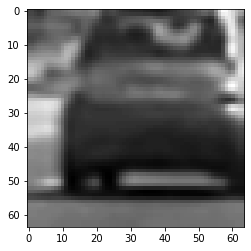

In [61]:
plt.imshow(x_gray[50,:,:], cmap='gray')

In [14]:
#x_gray = x_gray.reshape(17760,4096)
#x_gray.shape

In [34]:
from skimage.feature import hog
hogs=[]
hog_images=[]
for gray in x_gray:
    hog_feature, hog_image = hog(gray, orientations=9, pixels_per_cell=(8,8),
                                cells_per_block=(2,2),
                                block_norm='L2-Hys', transform_sqrt=False,
                                visualize=True, feature_vector=False)
    hogs.append(hog_feature)
    hog_images.append(hog_image)

In [47]:
np.array(hog_images).shape
hog_feature = np.array(hog_feature).flatten()

In [62]:
hog_features=[]
for i in hogs:
    hog_features.append(i.flatten())

In [63]:
hog_features = np.array(hog_features)

In [66]:
hog_features.shape

(17760, 1764)

In [33]:
#hog_image

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.9542613 , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 6.04524469, 0.        , ..., 0.        , 7.92970872,
        0.        ],
       ...,
       [0.        , 7.30894804, 0.        , ..., 0.        , 1.28847051,
        0.        ],
       [0.        , 0.        , 0.        , ..., 3.40248418, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [27]:
#hog_image.shape

(17760, 64)

In [86]:
x_prepared = np.concatenate([x_hist, hog_features], axis=1)

In [87]:
x_prepared.shape

(17760, 1796)

## Visualize Some of the Data

## Feature Extraction Method

In [ ]:
# Raw pixel intensity : (Color and Shape)
# Histogram of pixel intensity : (Color only)
# Gradients of pixel intensity : (Shape only)

## Feature Extraction

## Data Preparation

In [88]:
Xtrain, Xval, Ytrain, Yval = train_test_split(x_prepared, y_train, test_size = 0.3, stratify=y_train, random_state = 999)

In [68]:
len(Xtrain), len(Xval)

(12432, 5328)

In [69]:
Xtrain.shape

(12432, 1764)

## Classifier

In [32]:
#1 raw image

#skfold = StratifiedKFold(n_splits = 3, shuffle=True, random_state=999)

# 파라미터
C = [0.01, 0.1, 1, 5, 10, 15, 20, 50]
gamma = [0.001, 0.01, 0.1]

# 파라미터 그리드
params = {'C': C, 'gamma': gamma}

# 교차검증
svc_grid = GridSearchCV(estimator=SVC(probability=True), param_grid=params, cv=3, scoring="accuracy", n_jobs = -1)

# 모델 fitting
svc_grid.fit(Xtrain, Ytrain)

# 결과
print(svc_grid.best_score_)
print(svc_grid.best_params_)

0.6785714285714285
{'C': 5, 'gamma': 0.001}


In [ ]:
pred = svc_grid.best_estimator_.predict(Xval)

In [56]:
print(roc_auc_score(Yval, pred))
print(accuracy_score(Yval, pred))

0.6979303065575757
0.6983858858858859


In [72]:
#2 hog 적용
svc = SVC(probability=True, C = 5, gamma = 0.001, random_state=999)
svc.fit(Xtrain, Ytrain)
pred = svc.predict(Xval)
print(roc_auc_score(Yval, pred))
print(accuracy_score(Yval, pred))

0.968133034206944
0.9682807807807807


In [89]:
#3 hog + hist
svc = SVC(probability=True, C = 5, gamma = 0.001, random_state=999)
svc.fit(Xtrain, Ytrain)
pred = svc.predict(Xval)
print(roc_auc_score(Yval, pred))
print(accuracy_score(Yval, pred))

0.5172479150871873
0.5219594594594594


## Data Saving to Pickle